##  Sentiment Analysis for Movie Dataset


In [1]:
import pandas as pd
 
import matplotlib.pyplot as plt
import numpy as np
import glob
from bs4 import BeautifulSoup
from os import path
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, confusion_matrix,classification_report

from joblib import dump, load


# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# from subprocess import call

from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sohambee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
trainPos = glob.glob('aclImdb/train/pos/*.txt')
trainNeg = glob.glob('aclImdb/train/neg/*.txt')
print("total reviews for training : {}".format(len(trainPos)+len(trainNeg)))
testPos = glob.glob('aclImdb/test/pos/*.txt')
testNeg = glob.glob('aclImdb/test/neg/*.txt')
print("total reviews for testing : {}".format(len(testPos)+len(testNeg)))

total reviews for training : 25000
total reviews for testing : 25000


**Let's convert the text files into dataframe for further processing.**

In [3]:
def extractText(folder):
    allText = []
    textFiles = []
    for fileName in folder:
        with open(fileName,'r') as txtfile:
            text = txtfile.read()
            text = text.lower()
            cleanText = BeautifulSoup(text,"html.parser").text
            allText.append(cleanText)
            textFiles.append(fileName)
    return allText, textFiles

In [4]:
trainPosText,trainPosFiles = extractText(trainPos)
trainNegText,trainNegFiles = extractText(trainNeg)
testPosText,testPosFiles = extractText(testPos)
testNegText,testNegFiles = extractText(testNeg)

#for positive training files
dfTrainPos = pd.DataFrame(trainPosText,columns=['reviews'])
dfTrainPos['filename'] = trainPosFiles

#for negative training files
dfTrainNeg = pd.DataFrame(trainNegText,columns=['reviews'])
dfTrainNeg['filename'] = trainNegFiles

#for positive testing files
dfTestPos = pd.DataFrame(testPosText,columns=['reviews'])
dfTestPos['filename'] = testPosFiles

#for negative testing files
dfTestNeg = pd.DataFrame(testNegText,columns=['reviews'])
dfTestNeg['filename'] = testNegFiles


/tmp/ipykernel_6496/2287561018.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleanText = BeautifulSoup(text,"html.parser").text


In [5]:
dfTrainPos.head(5)

,reviews,filename
0,bromwell high is a cartoon comedy. it ran at t...,aclImdb/train/pos/0_9.txt
1,homelessness (or houselessness as george carli...,aclImdb/train/pos/10000_8.txt
2,brilliant over-acting by lesley ann warren. be...,aclImdb/train/pos/10001_10.txt
3,this is easily the most underrated film inn th...,aclImdb/train/pos/10002_7.txt
4,this is not the typical mel brooks film. it wa...,aclImdb/train/pos/10003_8.txt


In [6]:
dfTrainNeg.head(5)

,reviews,filename
0,story of a man who has unnatural feelings for ...,aclImdb/train/neg/0_3.txt
1,airport '77 starts as a brand new luxury 747 p...,aclImdb/train/neg/10000_4.txt
2,this film lacked something i couldn't put my f...,aclImdb/train/neg/10001_4.txt
3,"sorry everyone,,, i know this is supposed to b...",aclImdb/train/neg/10002_1.txt
4,when i was little my parents took me along to ...,aclImdb/train/neg/10003_1.txt


In [7]:
dfTestPos.head(5)

,reviews,filename
0,i went and saw this movie last night after bei...,aclImdb/test/pos/0_10.txt
1,actor turned director bill paxton follows up h...,aclImdb/test/pos/10000_7.txt
2,as a recreational golfer with some knowledge o...,aclImdb/test/pos/10001_9.txt
3,"i saw this film in a sneak preview, and it is ...",aclImdb/test/pos/10002_8.txt
4,bill paxton has taken the true story of the 19...,aclImdb/test/pos/10003_8.txt


In [8]:
dfTestNeg.head(5)

,reviews,filename
0,once again mr. costner has dragged out a movie...,aclImdb/test/neg/0_2.txt
1,this is an example of why the majority of acti...,aclImdb/test/neg/10000_4.txt
2,"first of all i hate those moronic rappers, who...",aclImdb/test/neg/10001_1.txt
3,not even the beatles could write songs everyon...,aclImdb/test/neg/10002_3.txt
4,brass pictures (movies is not a fitting word f...,aclImdb/test/neg/10003_3.txt


**let's build the wordcloud of the training data set initially for observing the frequency of words as well as their importance.**

In [9]:
stpwords = list(STOPWORDS)
stpwords.extend(stopwords.words('english'))
stpwords.extend(['movie','movies','film','films',
                 'actor','actress','cinema',
                 'story','br','role','dramas','drama',
                 'characters','character','director'])
stpwords = set(stpwords)


In [10]:
def wordCloud(text):
    wordcloud = WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).generate(text)
    return wordcloud

In [11]:
def plotWordCloud(wordcloud):
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [12]:
wordTrainPos = " ".join(review.strip() for review in dfTrainPos.reviews)
wordTrainNeg = " ".join(review.strip() for review in dfTrainNeg.reviews)

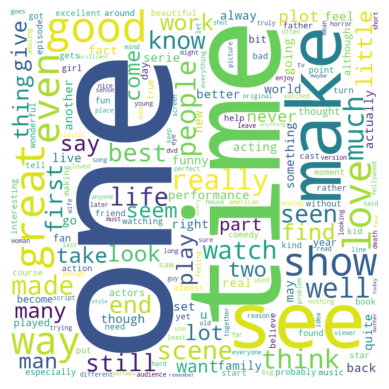

In [13]:
wordcloudPos = wordCloud(wordTrainPos)
plotWordCloud(wordcloudPos)

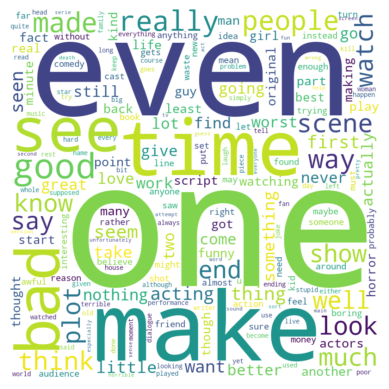

In [14]:
wordcloudNeg = wordCloud(wordTrainNeg)
plotWordCloud(wordcloudNeg)

**The wordcloud shown here shows the most common words that appear in the texts. However, the words shown here clearly donot define the sentiments of positive or negative reviews.**

**Let's see the weights of the words given by count vectorizer and visualize it.**

In [15]:
stop_words = stopwords.words('english')
cntVectorizerPos = CountVectorizer(binary=False, stop_words=list(stpwords), min_df=5, max_df=0.90,max_features=40000)
cntVectorizerNeg = CountVectorizer(binary=False, stop_words=list(stpwords), min_df=5, max_df=0.90,max_features=40000)
dataTrainPos = cntVectorizerPos.fit_transform(dfTrainPos['reviews'])
dataTrainNeg = cntVectorizerNeg.fit_transform(dfTrainNeg['reviews'])

/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['let'] not in stop_words.
  warnings.warn(


In [16]:
dataTrainPos.shape

(12500, 19529)

In [17]:
featureNamesPos=cntVectorizerPos.get_feature_names()
featureNamesNeg=cntVectorizerNeg.get_feature_names()

/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
def getTopFeatures(features,n,featuresName):
    dictionary = {}
    featuresSum = features.sum(axis=0)[0,:]
    featuresSum = np.squeeze(np.asarray(featuresSum))
    sortedIndices = np.argsort(-1*featuresSum)[0:n]
    for index in sortedIndices:
        dictionary[featuresName[index]]=featuresSum[index]
    return dictionary

In [19]:
sample = getTopFeatures(dataTrainPos,10,featureNamesPos)
sample

{'one': 13653,
 'good': 7721,
 'time': 6515,
 'great': 6418,
 'well': 6407,
 'see': 6025,
 'really': 5473,
 'even': 4961,
 'first': 4755,
 'much': 4687}

In [20]:
dictionaryPos = getTopFeatures(dataTrainPos,500,featureNamesPos)
dictionaryNeg = getTopFeatures(dataTrainNeg,500,featureNamesNeg)
  

In [21]:
def wordCloudFromFrequency(dictionary):
    return WordCloud(stopwords=stpwords, background_color="white",width=800,height=800).\
                                                generate_from_frequencies(dictionary)

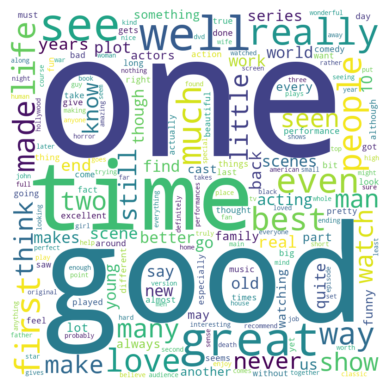

In [22]:
wordcloudPos = wordCloudFromFrequency(dictionaryPos)
plotWordCloud(wordcloudPos)


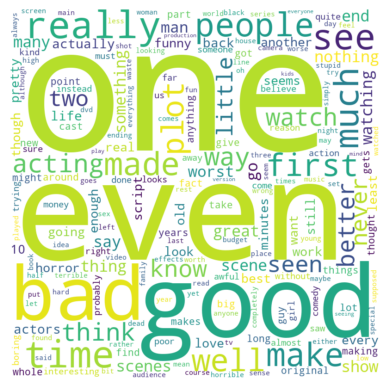

In [23]:
wordcloudNeg = wordCloudFromFrequency(dictionaryNeg)
plotWordCloud(wordcloudNeg)

**As seen from the wordcloud above, we observe top 500 most repetitive words and they too may not represent the words that are important in classifying the sentiments.**

**let's use some of the classical approaches through which we can know the type of words that are used in classifying sentiments. let's update the label by our own. The positive sentiments are given label 1 and negative sentiments are given label 0.**

## POS tags

In [24]:
wordsPos = [nltk.word_tokenize(x) for x in dfTrainPos['reviews']]
ptagsPos = [nltk.pos_tag(x) for x in wordsPos]

wordsNeg = [nltk.word_tokenize(x) for x in dfTrainNeg['reviews']]
ptagsNeg = [nltk.pos_tag(x) for x in wordsNeg]


In [45]:
wordsPos[0]

['bromwell',
 'high',
 'is',
 'a',
 'cartoon',
 'comedy',
 '.',
 'it',
 'ran',
 'at',
 'the',
 'same',
 'time',
 'as',
 'some',
 'other',
 'programs',
 'about',
 'school',
 'life',
 ',',
 'such',
 'as',
 '``',
 'teachers',
 "''",
 '.',
 'my',
 '35',
 'years',
 'in',
 'the',
 'teaching',
 'profession',
 'lead',
 'me',
 'to',
 'believe',
 'that',
 'bromwell',
 'high',
 "'s",
 'satire',
 'is',
 'much',
 'closer',
 'to',
 'reality',
 'than',
 'is',
 '``',
 'teachers',
 "''",
 '.',
 'the',
 'scramble',
 'to',
 'survive',
 'financially',
 ',',
 'the',
 'insightful',
 'students',
 'who',
 'can',
 'see',
 'right',
 'through',
 'their',
 'pathetic',
 'teachers',
 "'",
 'pomp',
 ',',
 'the',
 'pettiness',
 'of',
 'the',
 'whole',
 'situation',
 ',',
 'all',
 'remind',
 'me',
 'of',
 'the',
 'schools',
 'i',
 'knew',
 'and',
 'their',
 'students',
 '.',
 'when',
 'i',
 'saw',
 'the',
 'episode',
 'in',
 'which',
 'a',
 'student',
 'repeatedly',
 'tried',
 'to',
 'burn',
 'down',
 'the',
 'school'

In [25]:
ptagsNeg[0]

[('story', 'NN'),
 ('of', 'IN'),
 ('a', 'DT'),
 ('man', 'NN'),
 ('who', 'WP'),
 ('has', 'VBZ'),
 ('unnatural', 'JJ'),
 ('feelings', 'NNS'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('pig', 'NN'),
 ('.', '.'),
 ('starts', 'VBZ'),
 ('out', 'RP'),
 ('with', 'IN'),
 ('a', 'DT'),
 ('opening', 'NN'),
 ('scene', 'NN'),
 ('that', 'WDT'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('terrific', 'JJ'),
 ('example', 'NN'),
 ('of', 'IN'),
 ('absurd', 'JJ'),
 ('comedy', 'NN'),
 ('.', '.'),
 ('a', 'DT'),
 ('formal', 'JJ'),
 ('orchestra', 'NN'),
 ('audience', 'NN'),
 ('is', 'VBZ'),
 ('turned', 'VBN'),
 ('into', 'IN'),
 ('an', 'DT'),
 ('insane', 'NN'),
 (',', ','),
 ('violent', 'JJ'),
 ('mob', 'NN'),
 ('by', 'IN'),
 ('the', 'DT'),
 ('crazy', 'JJ'),
 ('chantings', 'NNS'),
 ('of', 'IN'),
 ('it', 'PRP'),
 ("'s", 'VBZ'),
 ('singers', 'NNS'),
 ('.', '.'),
 ('unfortunately', 'RB'),
 ('it', 'PRP'),
 ('stays', 'VBZ'),
 ('absurd', 'IN'),
 ('the', 'DT'),
 ('whole', 'JJ'),
 ('time', 'NN'),
 ('with', 'IN'),
 ('no', 'DT'),
 ('general', 

In [26]:
ptfeatsPos = [Counter([item[1] for item in sent if item[1].isalpha()]) for sent in ptagsPos]
ptfeatsNeg = [Counter([item[1] for item in sent if item[1].isalpha()]) for sent in ptagsNeg]

alltags = set([tag for sent in ptfeatsPos for tag in sent])
alltags |= set([tag for sent in ptfeatsNeg for tag in sent])
alltags = list(alltags)

In [27]:
ptfeatsNeg[1]
alltags

['UH',
 'WDT',
 'SYM',
 'DT',
 'NNS',
 'WRB',
 'VBN',
 'NNPS',
 'VBZ',
 'FW',
 'JJR',
 'NNP',
 'VB',
 'JJ',
 'RBS',
 'TO',
 'CD',
 'VBP',
 'EX',
 'POS',
 'PDT',
 'IN',
 'VBD',
 'VBG',
 'LS',
 'RBR',
 'JJS',
 'RB',
 'CC',
 'RP',
 'WP',
 'NN',
 'PRP',
 'MD']

In [28]:
ptvecPos = [[sentCnt[tag] for tag in alltags] for sentCnt in ptfeatsPos]
ptvecNeg = [[sentCnt[tag] for tag in alltags] for sentCnt in ptfeatsNeg]

print(len(ptvecPos), len(ptvecNeg))

12500 12500


In [46]:
ptvecNeg[0]

[0,
 1,
 0,
 15,
 4,
 0,
 3,
 0,
 7,
 0,
 1,
 0,
 5,
 19,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 14,
 0,
 2,
 0,
 0,
 0,
 6,
 1,
 3,
 1,
 21,
 5,
 4]

## Random Forest for Visualization

In [29]:
dfTrainPos['label'] = 1
dfTrainNeg['label'] = 0
dfTestPos['label'] = 1
dfTestNeg['label'] = 0


In [30]:
# trainDf = dfTrainPos.append(dfTrainNeg,ignore_index=True)
trainDf = pd.concat([dfTrainNeg, dfTrainPos])
trainDf = trainDf.sample(frac=1)#shuffle the dataframe to randomize

# testDf = dfTestPos.append(dfTestNeg,ignore_index=True)
testDf = pd.concat([dfTestNeg, dfTestPos])
# testDf = testDf.sample(frac=1)
trainDf.head(5)

,reviews,filename,label
6269,the people who are praising this film are the ...,aclImdb/train/neg/5929_2.txt,0
9628,this is a must see for anybody who loves thril...,aclImdb/train/pos/9483_10.txt,1
9503,"audrey, i know you truly cherish your husband ...",aclImdb/train/neg/9469_1.txt,0
5633,this is one of the great movies of the 80s in ...,aclImdb/train/pos/5358_10.txt,1
2069,"does anyone know, where i can see or download ...",aclImdb/train/pos/1587_10.txt,1


**We are considering the words that are present in at least 5 documents and rejecting the words that are present in 85% of the text files.**

In [31]:
countVect = CountVectorizer(binary=False, stop_words=stop_words,
                             token_pattern="[a-zA-Z]{2,}",#only considering words which have 2 alphabets in minimum
                             min_df=5,max_df=0.85)
trainFeatures = countVect.fit_transform(trainDf.reviews)
features = countVect.get_feature_names()

/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
print("the number of words taken for training sentiments: {}".format(len(features)))


the number of words taken for training sentiments: 26817


**lets choose the best hyperparameters.**

In [33]:
params = {
    'max_depth':[5,6,7],
    'max_features':[0.9, 1.0],
    'n_estimators':[10,15]
}

rfClassifier = RandomForestClassifier(random_state=6,n_jobs=-1)
gridSearch = GridSearchCV(rfClassifier, params,verbose=3,n_jobs=-1)
gridSearch.fit(trainFeatures, trainDf.label)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[CV 2/5] END max_depth=5, max_features=0.9, n_estimators=10;, score=0.691 total time=   5.7s
[CV 5/5] END max_depth=5, max_features=0.9, n_estimators=10;, score=0.689 total time=   5.2s
[CV 3/5] END max_depth=5, max_features=0.9, n_estimators=10;, score=0.709 total time=   5.9s
[CV 1/5] END max_depth=5, max_features=0.9, n_estimators=10;, score=0.690 total time=   6.2s
[CV 4/5] END max_depth=5, max_features=0.9, n_estimators=10;, score=0.701 total time=   6.8s
[CV 1/5] END max_depth=5, max_features=0.9, n_estimators=15;, score=0.691 total time=   7.3s
[CV 3/5] END max_depth=5, max_features=0.9, n_estimators=15;, score=0.699 total time=   7.8s
[CV 2/5] END max_depth=5, max_features=0.9, n_estimators=15;, score=0.693 total time=   8.0s
[CV 2/5] END max_depth=5, max_features=1.0, n_estimators=10;, score=0.691 total time=   7.1s
[CV 1/5] END max_depth=5, max_features=1.0, n_estimators=10;, score=0.690 total time=   7.7s
[CV 4/5] END max_depth=5, max_features=0.9, n_estimators=15;, score=0.

**For the given range of parameters, the best hyperparameters are given and best estimator is obtained.**

the accuracy score for training set : 0.7344
the accuracy score for testing set : 0.72464
[[ 7595  4905]
 [ 1979 10521]]
              precision    recall  f1-score   support

           0       0.79      0.61      0.69     12500
           1       0.68      0.84      0.75     12500

    accuracy                           0.72     25000
   macro avg       0.74      0.72      0.72     25000
weighted avg       0.74      0.72      0.72     25000



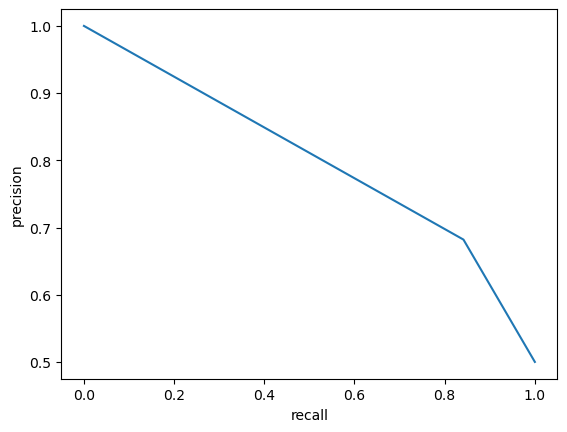

In [34]:
bestClassifier = gridSearch.best_estimator_
# dump(bestClassifier, '../models/rfClassifier.joblib')

# loadedModel = load('../models/rfClassifier.joblib')
loadedModel = bestClassifier
rfTrainPredict = loadedModel.predict(trainFeatures)
score = accuracy_score(trainDf.label, rfTrainPredict)
print("the accuracy score for training set : {}".format(score))

# for testing data
testFeatures = countVect.transform(testDf.reviews)
rfTestPredict = loadedModel.predict(testFeatures)
score = accuracy_score(testDf.label, rfTestPredict)
print("the accuracy score for testing set : {}".format(score))
print(confusion_matrix(testDf.label,rfTestPredict))
print(classification_report(testDf.label,rfTestPredict))
precision, recall, threshold = precision_recall_curve(testDf.label,rfTestPredict)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [35]:
featureImp = loadedModel.feature_importances_
indices = np.argsort(-featureImp)

trainWords = {}
for index in indices[0:100]:
    trainWords[features[index]] = featureImp[index]


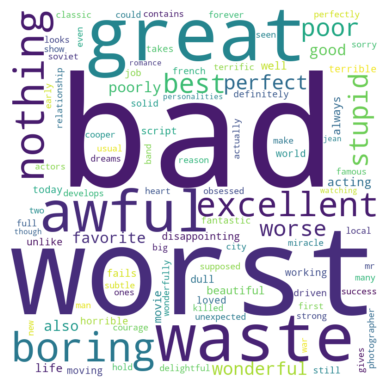

In [36]:
wordcloudAfterClassifier = wordCloudFromFrequency(trainWords)
plotWordCloud(wordcloudAfterClassifier)

In [37]:
# wordcloudAfterClassifier.to_file('../reports/wordcloud/wordcloudafterclassifier.png')

**The wordcloud above shows that after training, we have obtained the most important top 100 words that are used for classification. The words are mostly the adjective describing the positive and negative sentiments.**

## Logistic regression for positive and negative words

In [38]:
params = {
    'C':[0.07,0.09,0.1,0.2,0.3,0.5,1]
}

logisticModel = LogisticRegression(random_state=6,verbose=0,n_jobs=-1)
gridSearch = GridSearchCV(logisticModel, params,verbose=3,n_jobs=-1)
gridSearch.fit(trainFeatures, trainDf.label)
print(gridSearch.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 5/5] END ............................C=0.07;, score=0.892 total time=   2.5s
[CV 4/5] END ............................C=0.07;, score=0.887 total time=   2.7s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 2/5] END ............................C=0.09;, score=0.885 total time=   2.7s
[CV 2/5] END ............................C=0.07;, score=0.885 total time=   2.8s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 1/5] END ............................C=0.09;, score=0.882 total time=   2.9s
[CV 3/5] END ............................C=0.07;, score=0.890 total time=   3.0s
[CV 3/5] END ............................C=0.09;, score=0.889 total time=   3.0s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ............................C=0.07;, score=0.882 total time=   3.4s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END ............................C=0.09;, score=0.888 total time=   2.8s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 2/5] END .............................C=0.1;, score=0.885 total time=   2.9s
[CV 3/5] END .............................C=0.1;, score=0.887 total time=   2.8s
[CV 5/5] END ............................C=0.09;, score=0.891 total time=   3.1s
[CV 5/5] END .............................C=0.1;, score=0.892 total time=   2.7s
[CV 1/5] END .............................C=0.1;, score=0.883 total time=   3.1s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 4/5] END .............................C=0.1;, score=0.888 total time=   3.2s
[CV 1/5] END .............................C=0.2;, score=0.882 total time=   3.0s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 2/5] END .............................C=0.2;, score=0.884 total time=   2.9s
[CV 3/5] END .............................C=0.2;, score=0.883 total time=   2.7s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 2/5] END .............................C=0.3;, score=0.884 total time=   2.7s
[CV 5/5] END .............................C=0.2;, score=0.889 total time=   3.0s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 4/5] END .............................C=0.2;, score=0.882 total time=   3.1s
[CV 3/5] END .............................C=0.3;, score=0.883 total time=   2.7s
[CV 1/5] END .............................C=0.3;, score=0.880 total time=   3.2s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END .............................C=0.3;, score=0.881 total time=   3.1s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 5/5] END .............................C=0.3;, score=0.885 total time=   2.9s
[CV 1/5] END .............................C=0.5;, score=0.878 total time=   2.8s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END .............................C=0.5;, score=0.881 total time=   3.0s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 1/5] END ...............................C=1;, score=0.875 total time=   2.7s
[CV 3/5] END .............................C=0.5;, score=0.880 total time=   3.1s
[CV 4/5] END .............................C=0.5;, score=0.879 total time=   3.0s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 5/5] END .............................C=0.5;, score=0.883 total time=   3.0s
[CV 2/5] END ...............................C=1;, score=0.877 total time=   2.7s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

[CV 3/5] END ...............................C=1;, score=0.877 total time=   1.7s
[CV 4/5] END ...............................C=1;, score=0.880 total time=   1.6s
[CV 5/5] END ...............................C=1;, score=0.881 total time=   1.4s


/home/sohambee/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.07, n_jobs=-1, random_state=6)


In [39]:
posEg = {}
negEg = {}
bestModel = gridSearch.best_estimator_
indicesForPosEg = np.argsort(-1*bestModel.coef_)[:,0:100][0]
for i in indicesForPosEg[0:100]:
    posEg[features[i]] = bestModel.coef_[0,i]
indicesForNegEg = np.argsort(bestModel.coef_)[:,0:100][0]
for i  in indicesForNegEg[0:100]:
    negEg[features[i]] = -1*bestModel.coef_[0,i]

the accuracy of training set is :0.96372
the accuracy of testing set is :0.87876
[[11010  1490]
 [ 1541 10959]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



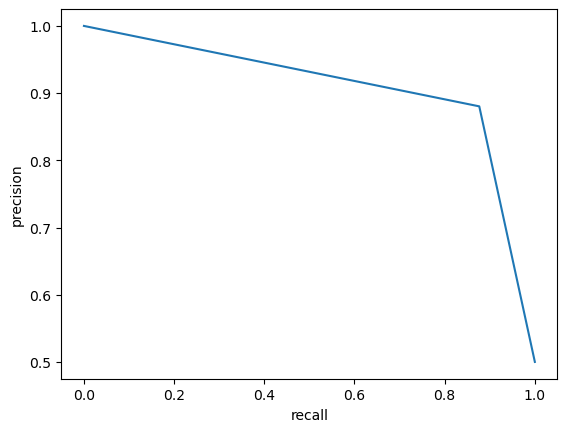

In [40]:
bestModel = gridSearch.best_estimator_
# dump(bestModel, '../models/logisticRegression.joblib')

# loadedModel = load('../models/logisticRegression.joblib')
loadedModel = bestModel

trainPredictLR = loadedModel.predict(trainFeatures)
testPredictLR = loadedModel.predict(testFeatures)

accuracyLRtrain = accuracy_score(trainDf.label, trainPredictLR)
accuracyLRtest = accuracy_score(testDf.label, testPredictLR)
print("the accuracy of training set is :{}".format(accuracyLRtrain))
print("the accuracy of testing set is :{}".format(accuracyLRtest))
print(confusion_matrix(testDf.label,testPredictLR))
print(classification_report(testDf.label,testPredictLR))
precision, recall, threshold = precision_recall_curve(testDf.label,testPredictLR)
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

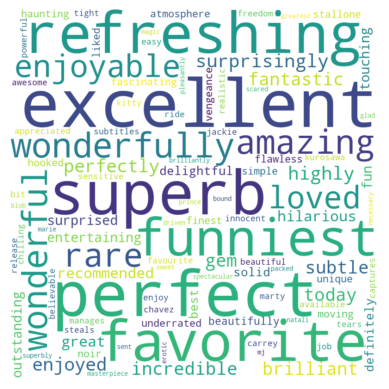

In [41]:
wordcloudLogRegPos = wordCloudFromFrequency(posEg)
plotWordCloud(wordcloudLogRegPos)

In [42]:
# wordcloudLogRegPos.to_file('../reports/wordcloud/wordcloudLogRegressionPos.png')

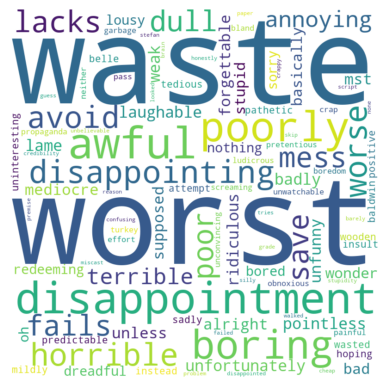

In [43]:
wordcloudLogRegNeg = wordCloudFromFrequency(negEg)
plotWordCloud(wordcloudLogRegNeg)

In [44]:
# wordcloudLogRegNeg.to_file('../reports/wordcloud/wordcloudLogRegressionNeg.png')

**The logistic regression showed the higher accurracy for classification and the wordclouds represent the important postive as well as negative words used for classification.**